# Capítulo 8

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

## 8.3.1 Árvores de classificação

Para esse capítulo, vamos usar o pacote `sklearn`. Começamos olhando para o dataset `Carseats`, com o objetivo de prever se `Sales` é maior do que 8. Como `Sales` é uma variável contínua, primeiro precisamos definir uma variável nova, `High`, que é `Y` se as vendas foram altas, e `N` caso contrário.

In [2]:
carseats = pd.read_csv('../data/Carseats.csv')
carseats['High'] = np.where(carseats.Sales > 8, 'Y', 'N')

carseats.ShelveLoc = pd.factorize(carseats.ShelveLoc)[0]
carseats.Urban = carseats.Urban.map({'No':0, 'Yes':1})
carseats.US = carseats.US.map({'No':0, 'Yes':1})

In [3]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,Y
1,11.22,111,48,16,260,83,1,65,10,1,1,Y
2,10.06,113,35,10,269,80,2,59,12,1,1,Y
3,7.40,117,100,4,466,97,2,55,14,1,1,N
4,4.15,141,64,3,340,128,0,38,13,1,0,N


In [4]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    object 
dtypes: float64(1), int64(10), object(1)
memory usage: 37.6+ KB


Vamos dividir os dados em treino e teste, com 200 amostras de treino.

In [5]:
X = carseats.drop(['Sales', 'High'], axis=1)
y = carseats.High
train_size = 200
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, 
                                    test_size=X.shape[0]-train_size, random_state=0)

Para criar a árvore, podemos usar como critérios de split tanto 'gini' quanto 'entropy'. Vamos optar pela primeira opção.

In [6]:
criteria = "gini" 
max_depth = 6 
min_sample_leaf = 4
tree_gini = DecisionTreeClassifier(criterion=criteria, random_state=100,
                                  max_depth=max_depth, min_samples_leaf=min_sample_leaf)
tree_gini.fit(X_train, y_train)
print(f"Acurácia média no treino: {tree_gini.score(X_train, y_train)}")

Acurácia média no treino: 0.9


Uma vantagem de árvores é que elas podem ser facilmente visualizadas.

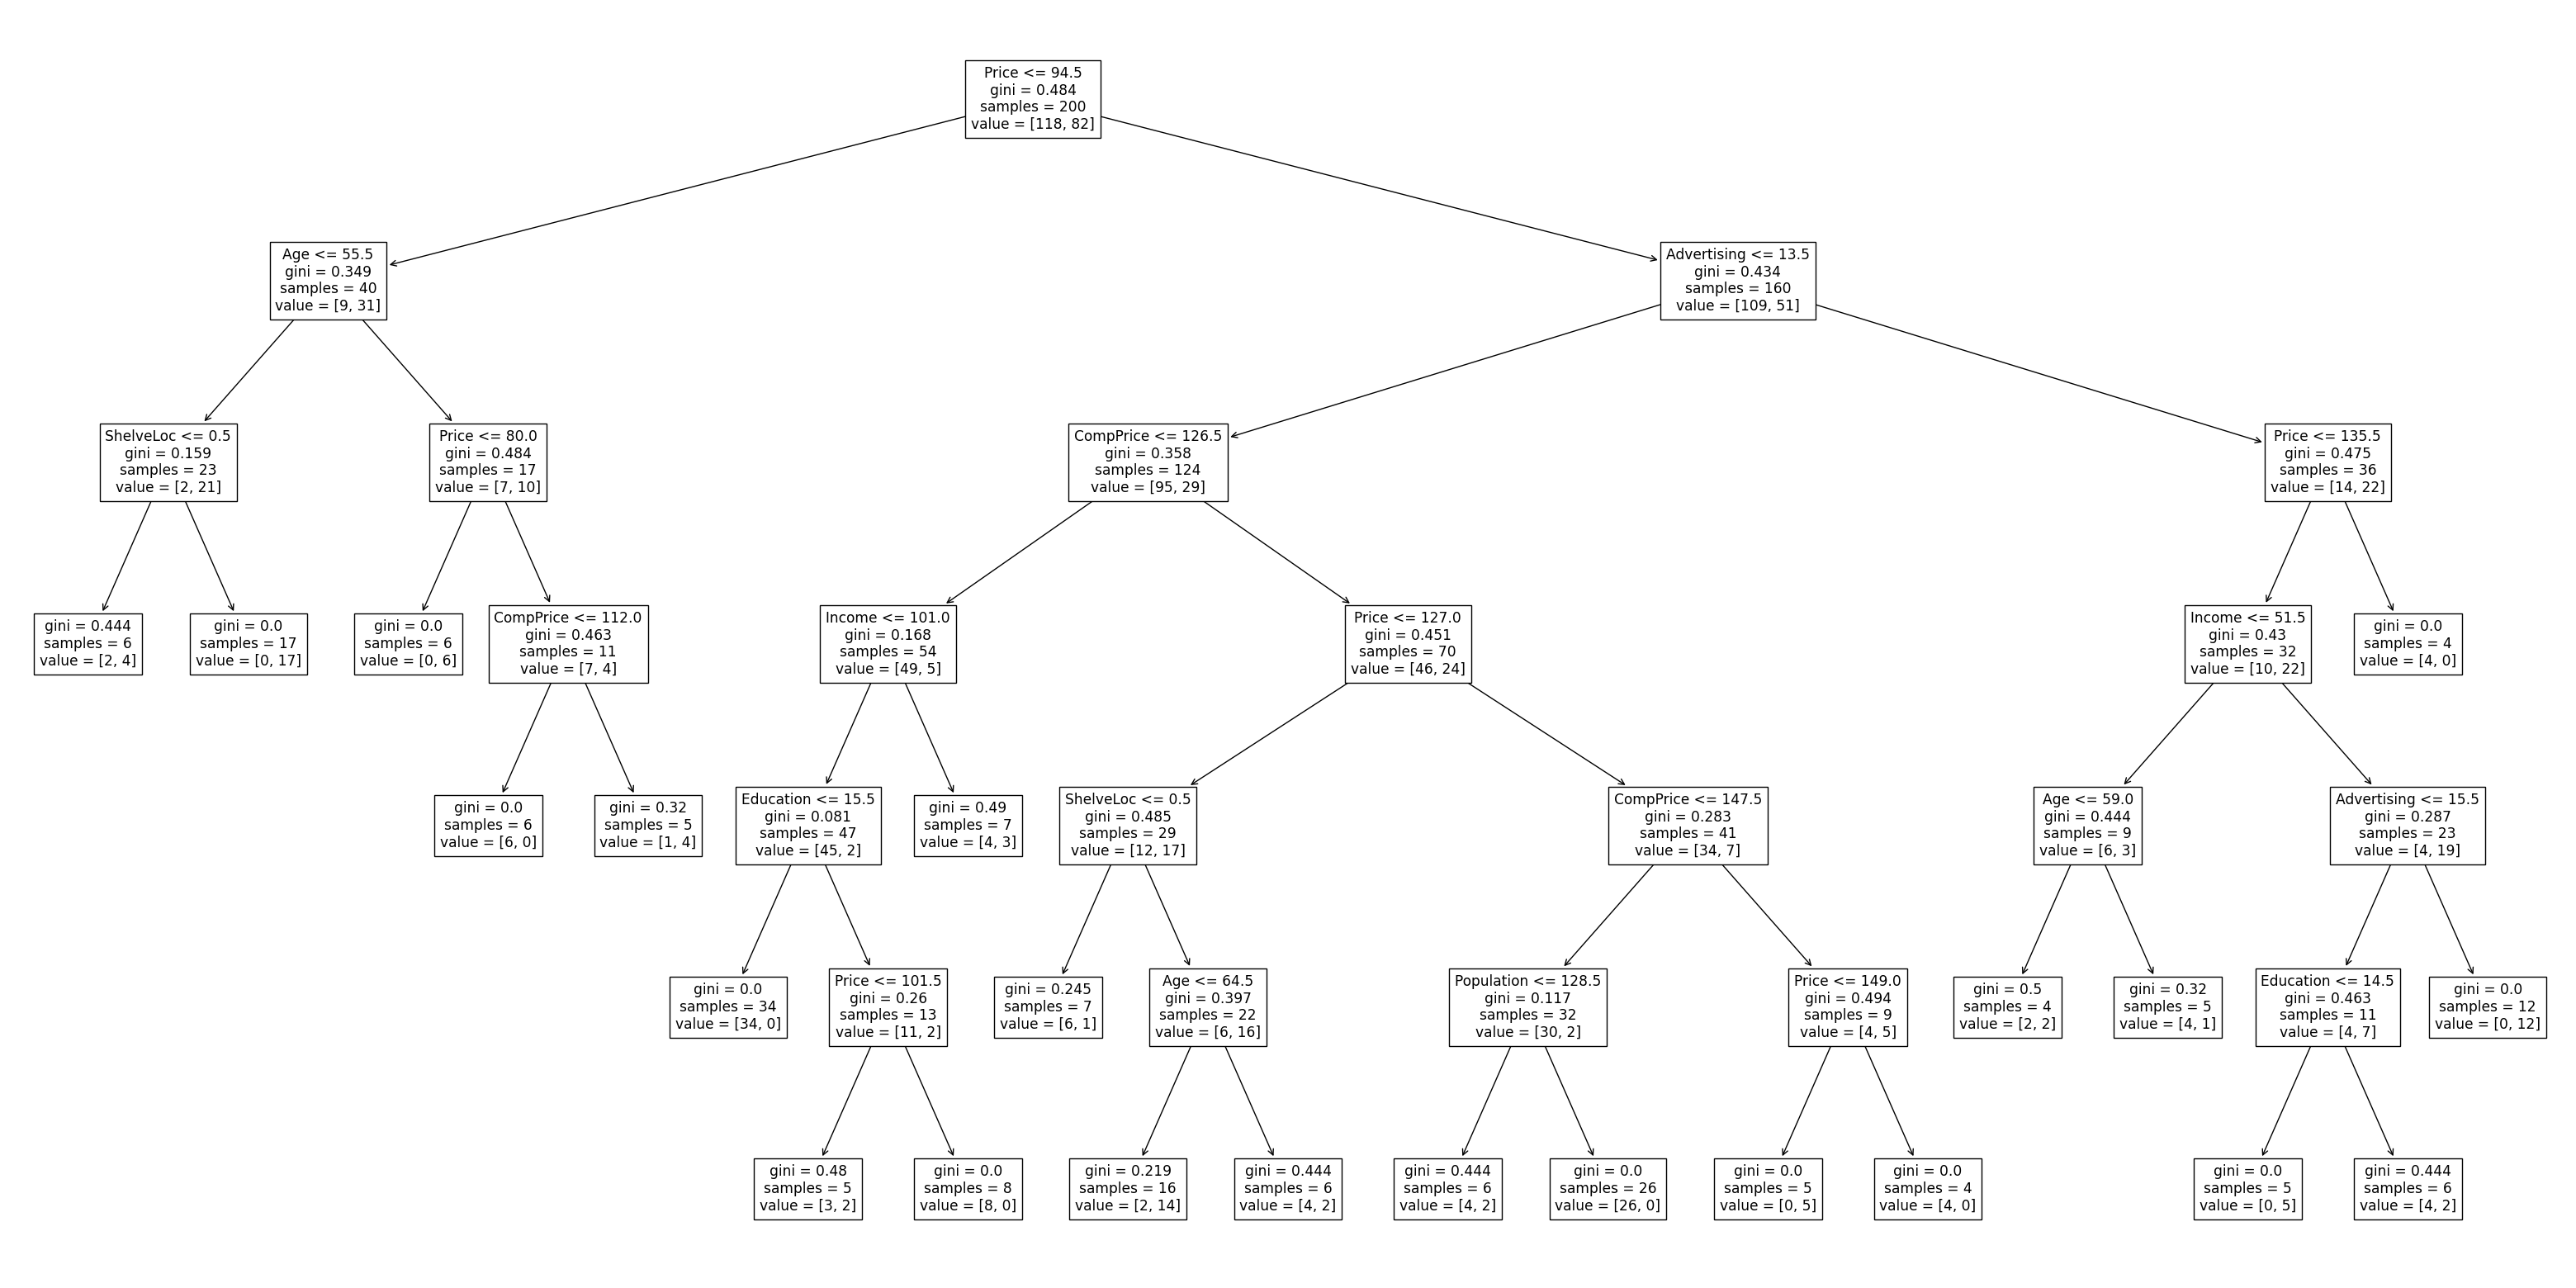

In [7]:
plt.figure(figsize=(40,20))
plot_tree(tree_gini, feature_names = X_train.columns)
plt.show()

Para obter uma avaliação mais precisa da acurácia do modelo, podemos olhar para a matriz de confusão, tanto no treino quanto no teste.

In [8]:
y_pred_train = tree_gini.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred_train).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print("Train Accuracy is ", accuracy_score(y_train,y_pred_train)*100)

      No  Yes
No   113   15
Yes    5   67
Train Accuracy is  90.0


In [9]:
y_pred = tree_gini.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print("Test Accuracy is ", accuracy_score(y_test,y_pred)*100)

     No  Yes
No   99   32
Yes  19   50
Test Accuracy is  74.5


Ou seja, a acurácia de teste é bem menor do que a acurácia de treino, então provavelmente estamos incorrendo em overfitting. A partir daí, podemos começar a olhar com mais cuidado para os hiperparâmetros das árvores e tentar atenuar o problema.

## 8.3.2 Árvores de regressão

Outra vantagem de árvores é que elas funcionam tanto para classificação quanto para regressão. Para mostrar como elas funcionam para regressão, vamos usar o dataset `Boston`.

## 8.3.2 Fitting Regression Trees

In [10]:
boston = pd.read_csv('../data/Boston.csv', header=0, index_col=0)
X = boston.drop('medv', axis=1)
y = boston.medv
train_size = 0.5 
max_depth = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)
regr_tree = DecisionTreeRegressor(max_depth=max_depth)
regr_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

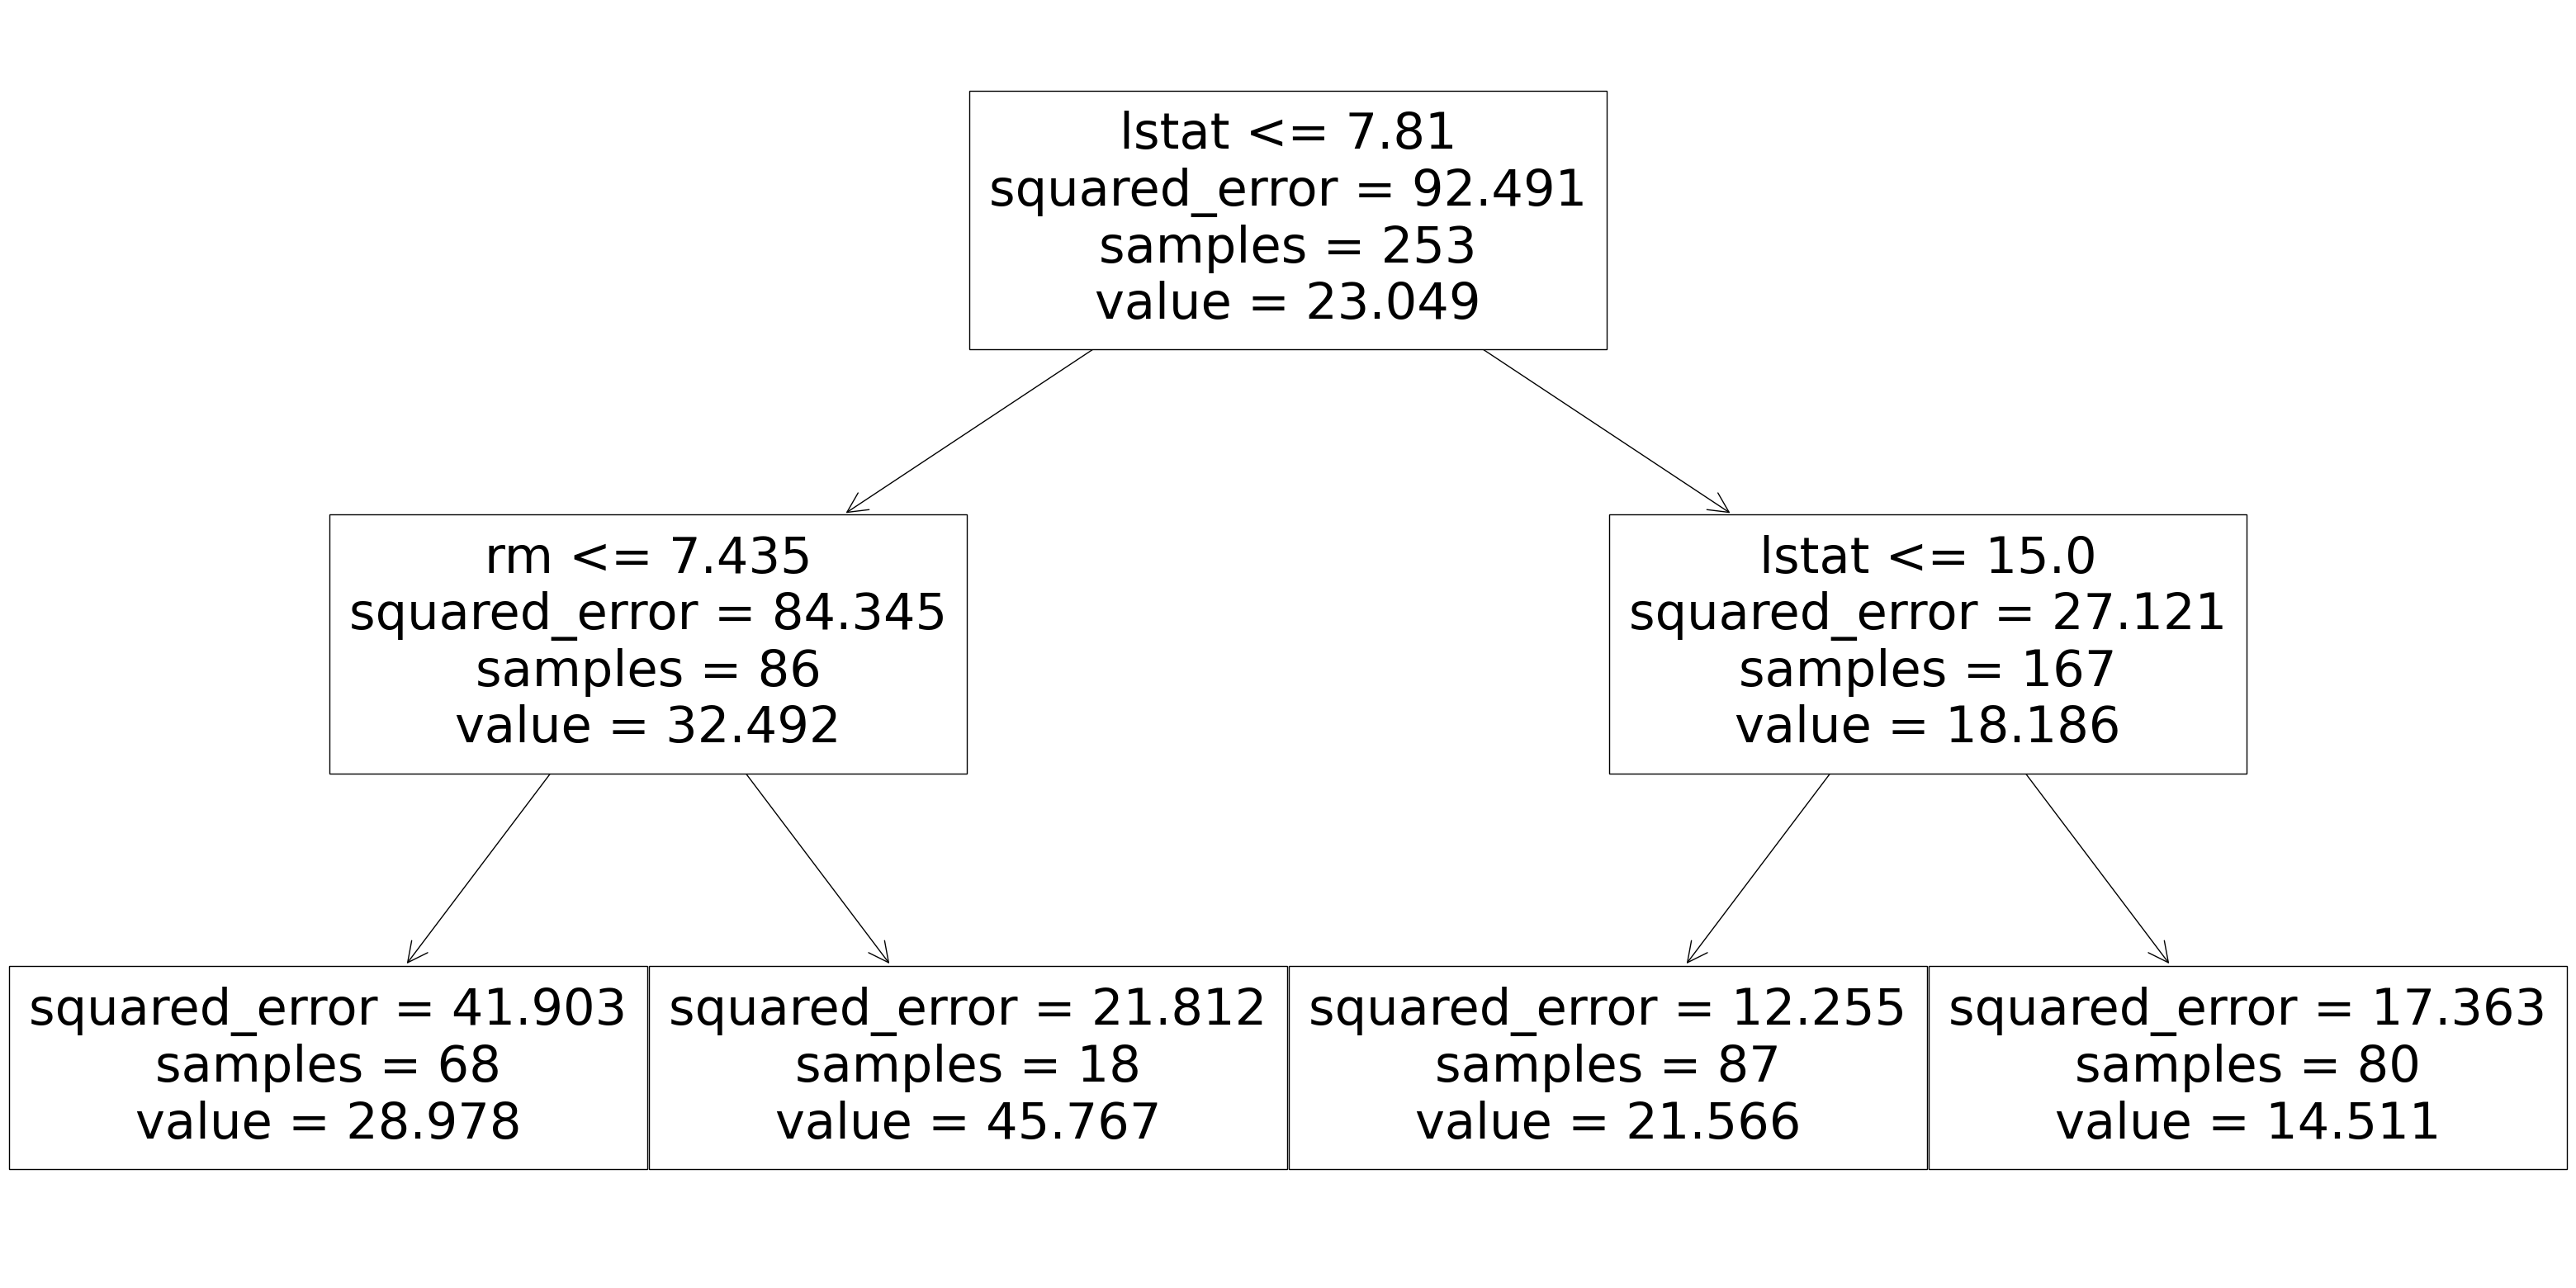

In [11]:
plt.figure(figsize=(40,20))
plot_tree(regr_tree, feature_names = X_train.columns)
plt.show()

In [ ]:
y_pred = regr_tree.predict(X_test)
print(f"MSE de teste: {mean_squared_error(y_test, y_pred)}")

## 8.3.3 Bagging e Random Forests

Vamos aplicar bagging e random forests (RF) no mesmo dataset `Boston`. Bagging é um método de ensemble, então combina diversas árvores de decisão e, dessa maneira, reduz a variância do modelo. Assim como árvores, bagging funciona tanto para classificação quanto para regressão. Por outro lado, o ensembling depende de aleatoriedade, então os resultados dessa subseção podem variar.

In [12]:
all_features = X_train.shape[1]
regr_bagging = RandomForestRegressor(max_features=all_features, random_state=1)
regr_bagging.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=1)

In [13]:
y_pred = regr_bagging.predict(X_test)
print(f"MSE de teste: {mean_squared_error(y_test, y_pred)}")

MSE de teste: 16.515353122529653


Bagging, em geral, é de fato bem melhor do que usar uma árvore única.

Como vimos, o problema em usar bagging é que as árvores acabam sendo parecidas entre si, então tirar a média tem um efeito limitado. Por isso, podemos limitar o número de features sendo usadas (e.g., para algo como $\sqrt{p}$) e, como consequência da redução de correlação entre as árvores, melhorar os resultados. Vamos ver se funciona no nosso caso.

In [14]:
regr_rf = RandomForestRegressor(max_features=int(np.sqrt(X_train.shape[1])), random_state=1)
regr_rf.fit(X_train, y_train)

y_pred = regr_rf.predict(X_test)
print(f"MSE de teste: {mean_squared_error(y_test, y_pred)}")

MSE de teste: 15.625995952569168


De fato, usar RF reduz ainda mais o erro de teste.

Outra vantagem de usar RF é poder interpretar o modelo de maneiras diferentes. Uma é via a medida de importância de variáveis.

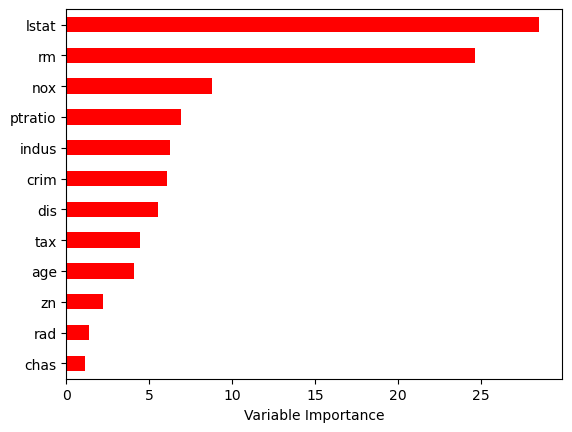

In [15]:
Importance = pd.DataFrame({'Importance':regr_rf.feature_importances_*100}, index=X_train.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.3.4 Boosting

Ao passo em que bagging e RF geram várias árvores e tiram a média, boosting cria árvores sequencialmente, treinando cada árvore nos erros das árvores que vieram anteriormente. Abaixo, usamos gradient boosting com 500 árvores e de altura 4.

In [16]:
regr_boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=1)
regr_boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=1)

Vamos ver se as variáveis recebem uma importância similar a quando usamos RF. Parece que sim.

In [ ]:
feature_importance = regr_boost.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [17]:
y_pred = regr_boost.predict(X_test)
print(f"MSE de teste: {mean_squared_error(y_test, y_pred)}")

MSE de teste: 15.130308204033252


O erro é um pouco maior do que usando RF, mas não muito maior.

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
param = {'max_depth': 6, 'eta': 0.01, 'objective': 'reg:squarederror', 'nthread': 4}
num_round = 10000
bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtest)
print(f"MSE de teste: {mean_squared_error(y_test, y_pred)}")

MSE de teste: 15.089452844945681


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

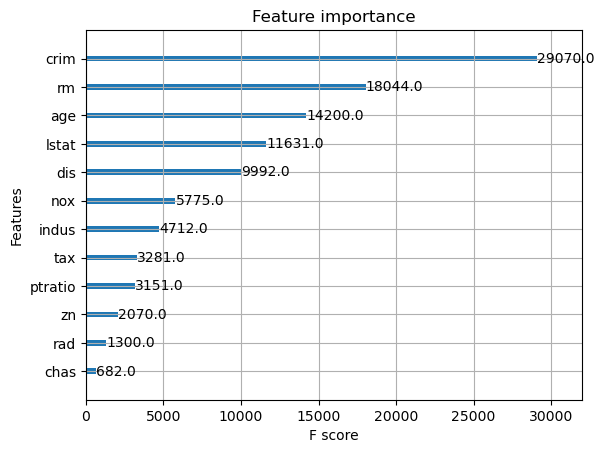

In [20]:
xgb.plot_importance(bst)

O último método do capítulo, BART, não possui uma implementação muito eficiente em Python, então não vamos olhar para esse método agora.